In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as tf
import torchvision.models as models

import copy

In [54]:
out_size = 256 # This will be the future size of the ouptut'

def load_image(image_name):
    '''loads an image and returns it as a torch tensor of the desired size
    '''
    image = Image.open(image_name)
    size = (256, 128)
    image = image.resize(size) # Resize of the image
    load_module = tf.Compose([tf.Resize(out_size), tf.ToTensor()])  # transformation of the image into a torch tensor
    image = load_module(image).unsqueeze(0) # Change of dimension to feed vgg
    return image.to('cpu', torch.float)


style_img = load_image("Images/nuit_etoilee.jpg")
content_img = load_image("Images/city.jpg")

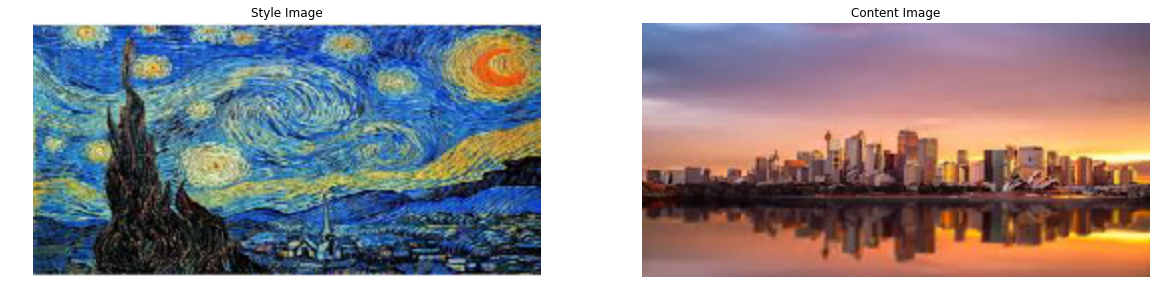

In [55]:
def show_image(tensor, title=None):
    ''' Display the image from a torch tensor
    '''
    image = tensor.clone()  # deep copy
    image = image.squeeze(0)
    unloader = tf.ToPILImage()  # tensor to to PIL Image
    image = unloader(image)
    plt.axis('off')
    plt.set_cmap('hot')
    plt.imshow(image)
    if title is not None:
        plt.title(title)


# Let's draw the pictures we will work on
        
plt.figure(figsize=(20,12))
    
plt.subplot(1, 2, 1)
show_image(style_img, title='Style Image')

plt.subplot(1, 2, 2)
show_image(content_img, title='Content Image')

In [56]:
class ContentLoss_Module(nn.Module):
    '''Defines the content loss and creates the forward loss in a way it will be useful for the optimization later
    following https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html'''
    
    def __init__(self, content_image):
        super(ContentLoss_Module, self).__init__()
        self.content_image = content_image.detach() # Needed to see the target as a value and not a Variable

    def forward(self, generated_image):
        self.loss = F.mse_loss(generated_image, self.content_image) # Computation of the loss
        return generated_image
    


In [57]:
def get_gram_matrix(out_features):
    '''Compute the Gram matrix of input (one intermediate output of the vgg19)'''
    batchlen, channelsnbr, nrows, ncols = out_features.size() 
    # a=batch size(=1)
    # b=number of feature maps (number of channels of the output)
    # (c,d)=dimensions of a features map (N=c*d) (size of the channels)

    feats = out_features.view(batchlen * channelsnbr, nrows * ncols)  # reshape of the matrix (np.reshape)

    GramMatrix = torch.mm(feats, feats.t())  # Gram Matrix
    # The value is normalized so that each channel has an equivalent weight in the computation of the style loss
    return GramMatrix/(batchlen * channelsnbr * nrows * ncols)

In [58]:
class StyleLoss_Module(nn.Module):
    '''Same as ContentLoss_Module but to compute the Style Loss'''

    def __init__(self, style_image):
        super(StyleLoss_Module, self).__init__()
        self.style_image = get_gram_matrix(style_image).detach()

    def forward(self, generated_image):
        Gramatrix = get_gram_matrix(generated_image)
        self.loss = F.mse_loss(Gramatrix, self.style_image) # Computation of the loss
        return generated_image

In [59]:
vgg = models.vgg19(pretrained=True).features.to('cpu').eval() # Loading the vgg19 trained model

In [60]:
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to('cpu')
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to('cpu') # These are the standard value to normalize a model(see the link below)


class Normalization_Module(nn.Module):
    # Normalization following https://github.com/pytorch/examples/blob/master/imagenet/main.py#L92-L93
    
    def __init__(self, mean, std):
        super(Normalization_Module, self).__init__()
        # Definition and reshape of the previous tensors
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize image
        return (img - self.mean) / self.std

In [61]:
# These are the names of the layers whose outputs will be used to compute the losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(vgg, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers,
                               style_layers=style_layers):
    
    '''Recreates the vgg models and adds the losses modules so that the losses are computed easily (just like any torch module)'''
    
    vgg_copy = copy.deepcopy(vgg) # trained vgg19

    # normalization module installed before the input of the vgg
    normalization = Normalization_Module(normalization_mean, normalization_std).to('cpu')

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization) # Let's make sure that the inputs will be normalized before being fed to the network

    i = 0  # increment every time we see a conv
    for layer in vgg_copy.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
            
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        model.add_module(name, layer) # recreating the model layer by layer

        if name in content_layers:
            content_target = model(content_img).detach() # feeding the vgg with the content image
            content_loss = ContentLoss_Module(content_target) # Creating loss
            model.add_module("content_loss_{}".format(i), content_loss) # Adding it to the model
            content_losses.append(content_loss)

        if name in style_layers:
            style_target = model(style_img).detach() # fedding the vgg with the style image
            style_loss = StyleLoss_Module(style_target) # Creating loss
            model.add_module("style_loss_{}".format(i), style_loss) # Adding it to the model
            style_losses.append(style_loss)
            

    return model, style_losses, content_losses

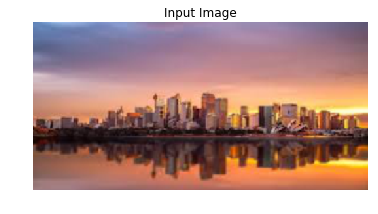

In [62]:
# The generated image is initialized as the content image
input_img = content_img.clone()

plt.figure()
show_image(input_img, title='Input Image')

In [63]:
def get_optimizer(input_image):
    # this line shows that input_image is a parameter that requires a gradient
    # We will use the module LBFGS of torch and the fact the network can compute the gradients of our losses to optimize the losses
    # Instead of deriving ourselves or using an external optimizing tool
    optimizer = optim.LBFGS([input_image.requires_grad_()])
    return optimizer

In [64]:
def get_tv_loss(x):
    '''returns TV loss of x'''
    batchlen, colors, nrows, ncols = x.size()
    
    a = (x[:, :, :nrows - 1, :ncols - 1] - x[:, :, 1:, :ncols - 1])**2      
    b = (x[:, :, :nrows - 1, :ncols - 1] - x[:, :, :nrows - 1, 1:])**2
    return torch.sum(a + b)

In [65]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=100,
                       style_weight=5000000, content_weight=1, tv_weight = 0.0):
    '''Style Transfer'''

    model, style_losses, content_losses = get_style_model_and_losses(vgg, normalization_mean, 
                                                                     normalization_std, style_img, content_img) # Get model and losses
    optim = get_optimizer(input_img) # Get optimizer

    step = [0]
    while step[0] <= num_steps:

        def closure(): # Defines optimizing function
            
            input_img.data.clamp_(0, 1) # Be sure we are within the right range
            
            optim.zero_grad()
            model(input_img)
            style_score = 0 # Initialize losses
            content_score = 0

            for styloss in style_losses: # Sum the losses from the different intermediate outputs
                style_score += styloss.loss
            for contenloss in content_losses:
                content_score += contenloss.loss

            tv_score = get_tv_loss(input_img) # computes tv loss
            
    
            total_loss = style_weight * style_score + content_weight * content_score + tv_weight * tv_score # Sum of all different kinf of losses
            total_loss.backward() # One optimizing step

            step[0] += 1
            if step[0] % 50 == 0: # Some printing
                print('Step:', step[0], 'on', num_steps)
                print('Style Loss :', style_score.item() * style_weight, 'Content Loss:', content_score.item())

            return style_score + content_score

        optim.step(closure)

    input_img.data.clamp_(0, 1) # Same as clip with a numpy array
    
    return input_img

C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Step: 50 on 100
Style Loss : 650.949077680707 Content Loss: 20.284629821777344
Step: 100 on 100
Style Loss : 195.21288777468726 Content Loss: 20.861055374145508


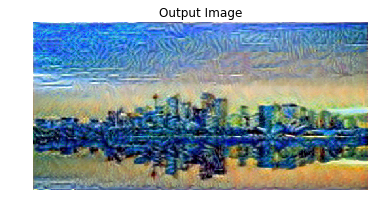

In [66]:
output = run_style_transfer(vgg, vgg_normalization_mean, vgg_normalization_std,
                            content_img, style_img, input_img, num_steps=100) # Let's run everything

show_image(output, title='Output Image') # Displaying the results